# Notebook For Figure 1 Method Paper

### Imports  
All functions are in behavior_analysis_functions.py

In [1]:
import os
import glob
from processing_TowerCoordinates import *
from processing_session_trajectory import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import numpy as np
import pickle
import scipy.ndimage as ndimage
from scipy.stats import wilcoxon
from processing_TowerCoordinates import *
from datetime import date


plt.style.use('paper.mplstyle')

#from PlottingFunctions import *




# Getting mice data
Define the folder where your MOUXXX folder are, generate a list of MOUXXX folders and for each mice a list of sessions

In [2]:
# Finding and importing data

# indicate where the data are
# path_to_data_folder is the path of the folder where you store your different mice.

# Windows:
# path_to_data_folder='C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
# Linux:
# path_to_data_folder '/home/david/Documents/Code/ForagingProject/Patchouris/patchouris/Sample_Data/'
# MacOs
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'


#path_to_data_folder='/home/david/Documents/David/Data/'
#path_to_data_folder='/LocalData/ForagingMice/JAK2Data'
#path_to_data_folder='/LocalData/ForagingMice/MaudData'
path_to_data_folder='/LocalData/ForagingMice/4TowerTaskMethodPaper/KenzaData'
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/KenzaData'


pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

# List all mice in the data folder (If you want to process all the mice in your data folder),
mice_list = [os.path.basename(path) for path in glob.glob(pattern_of_MOU_Folders)]
mice_list=sorted(mice_list)

# Print the number of mice, the list of mice, and add an empty line
print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder: {", ".join(mice_list)}\n')


#If you want to process a subset of mice uncomment the line below and comment the 2 lines above

#mice_list: list[str] = ["MOU2334"]  # For processing  a single mice. Equivalent to mice_list = ["MOU2334"] but more correct as it forces to create a list of string
#mice_list=['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']
#print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions:')
    print(session_list[mouse], '\n')


Found 36 mice in the data folder: MOUKA266, MOUKA267, MOUKA268, MOUKA269, MOUKA270, MOUKA271, MOUKA274, MOUKA275, MOUKA276, MOUKA277, MOUKA278, MOUKA279, MOUKA286, MOUKA287, MOUKA288, MOUKA289, MOUKA290, MOUKA291, MOUKA296, MOUKA297, MOUKA298, MOUKA299, MOUKA300, MOUKA301, MOUKA302, MOUKA303, MOUKA304, MOUKA305, MOUKA306, MOUKA307, MOUKA308, MOUKA309, MOUKA310, MOUKA311, MOUKA312, MOUKA313

Hello, I'm MOUKA266! I have foraged for 17 sessions:
['MOUKA266_20230531-1433', 'MOUKA266_20230601-0925', 'MOUKA266_20230601-1507', 'MOUKA266_20230602-0857', 'MOUKA266_20230602-1450', 'MOUKA266_20230605-0924', 'MOUKA266_20230605-1606', 'MOUKA266_20230606-1052', 'MOUKA266_20230606-1626', 'MOUKA266_20230607-0929', 'MOUKA266_20230607-1439', 'MOUKA266_20230608-0949', 'MOUKA266_20230608-1538', 'MOUKA266_20230609-1034', 'MOUKA266_20230609-1604', 'MOUKA266_20230612-0941', 'MOUKA266_20230612-1505'] 

Hello, I'm MOUKA267! I have foraged for 18 sessions:
['MOUKA267_20230531-1519', 'MOUKA267_20230601-0939', 'M

# Definition of functions

In [3]:
def cm2inch(value):
    return value/2.54

In [4]:
def plot_trajectory_with_trapezes(smoothed_Xpositions, smoothed_Ypositions, all_trapezes_coordinates,
                                  traject_time, time_start=None,time_end=None, 
                                  ax=None, xlim=(0, 512), ylim=(0, 512),  session_number='Session 1', 
                                  mouse_id='Mouse ID',border_colors=None, plot_borders=True, 
                                  fill_trapezes=False, fill_colors=None, linewidth=1):
    """
    Plots the trajectory along with trapezes, allowing customization of border and fill colors, and hides all spines.
    
    Parameters:
        smoothed_Xpositions (list or np.array): Smoothed X positions of the trajectory.
        smoothed_Ypositions (list or np.array): Smoothed Y positions of the trajectory.
        all_trapezes_coordinates (dict): Coordinates of each trapeze, organized by tower.
        ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis for plotting. If None, a new axis is created.
        xlim (tuple): Limits for the x-axis. Default is (0, 512).
        ylim (tuple): Limits for the y-axis. Default is (0, 512).
        session_number (str): Session number to be used as the title of the plot.
        mouse_id (str): Mouse ID to be used as the y-axis label.
        border_colors (list): List of 4 colors for trapeze borders. Default is None.
        plot_borders (bool): Whether to plot trapeze borders. Default is True.
        fill_trapezes (bool): Whether to fill the trapezes with color. Default is False.
        fill_colors (list): List of 4 colors to fill the trapezes with. Default is None.
    """
    # Default to black borders and lightblue fill if not specified
    if border_colors is None:
        border_colors = ['lightblue'] * 4
    if fill_colors is None:
        fill_colors = ['lightblue'] * 4

    # Create a new figure and axis if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
        axcreated = 1
    else:
        axcreated = 0

    # Ensure equal aspect ratio to create a perfect square plot
    #ax.set_aspect('equal')

    # Hide all spines (removes the box around the plot)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Remove x and y axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

    #####################################################

    # Analyze entire session or not
    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    start_idx = np.searchsorted(traject_time, time_start)
    end_idx = np.searchsorted(traject_time, time_end)

    # Extract data from the selected period
    selected_Xpositions = smoothed_Xpositions[start_idx:end_idx]
    selected_Ypositions = smoothed_Ypositions[start_idx:end_idx]
    #selected_time = traject_time[start_idx:end_idx]

    #####################################################

    # Plot the trapezes with varying border and fill colors
    for i, (tower, trapezes) in enumerate(all_trapezes_coordinates.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            # Close the polygon by appending the first vertex
            coordinates_copy = coordinates + [coordinates[0]]
            x_coords, y_coords = zip(*coordinates_copy)
            
            # Fill the trapezes if requested
            if fill_trapezes:
                ax.fill(x_coords, y_coords, color=fill_colors[j % len(fill_colors)], alpha=0.5)
            
            # Plot trapeze borders if requested
            if plot_borders:
                ax.plot(x_coords, y_coords, color=border_colors[j % len(border_colors)], linestyle='--')

    # Plot the trajectory on top of the trapezes
    ax.plot(selected_Xpositions, selected_Ypositions, label='Trajectory', color='black', linewidth=linewidth)

    # Set plot limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set the title to the session number
    #ax.set_title(session_number)

    # If no axis was provided, show the plot
    if axcreated:
        plt.show()


In [5]:
def plot_mice_sessions(mice_list, sessions_to_plot, path_to_data_folder, time_start=None, time_end=None, axs=None, linewidth=1):
    num_mice = len(mice_list)
    num_sessions = len(sessions_to_plot)
    
    # if axs==[]:

    #     # Dynamically compute figure size (you can adjust scaling factors if needed)
    #     fig_width = num_sessions * 3  # Each subplot has width of 4 units
    #     fig_height = num_mice * 3     # Each subplot has height of 4 units
    
    #     fig, axs = plt.subplots(num_mice, num_sessions, figsize=(fig_width, fig_height)) # TOM

    # else:

    #     for i in range(num_mice):

    #         for j in range(num_sessions):

    #             axs[i,j].add_subplot(gs[i,j])

        #axs_top = [axs[f"B{i+1}"] for i in range(len(sessions_to_plot)) ]
        #axs_bot = [axs[f"B{i+4}"] for i in range(len(sessions_to_plot)) ]

    axs = np.array(axs)
    
    # Ensure axs is 2D array, even if there is only one row or column
    if num_mice == 1:
        axs = np.expand_dims(axs, axis=0)
    if num_sessions == 1:
        axs = np.expand_dims(axs, axis=1)

    # Iterate through each mouse
    for mouse_idx, mouse in enumerate(mice_list):
        folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)

        # Get the list of sessions for the current mouse
        sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                      if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                      and name.startswith('MOU')])

        # Iterate through each session for the current mouse
        for session_idx, session_to_plot_index in enumerate(sessions_to_plot):
            session_to_plot = sessions_to_process[session_to_plot_index]

            # For the first session, extract trapeze and tower data (you can adjust if needed)
            if session_idx == 0:
                trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_plot)
                all_trapezes_coordinates_cm = generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

            # Define the pickle file path
            output_pickle_filename = f"{session_to_plot}_basic_processing_output.pickle"
            output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_plot, output_pickle_filename)
            
            # Check if the pickle file exists
            if not os.path.exists(output_pickle_filepath):
                print(f'Pickle file does not exist for session {session_to_plot}, skipping .....')
                continue
            
            # Load the pickle file
            with open(output_pickle_filepath, 'rb') as file:
                session_data = pickle.load(file)
            
            # Get the positions
            positions = np.array(session_data['positions'])
            traject_time = np.array(session_data['timeofframes'])

            if mouse_idx==0:
                session_id = f'session {session_to_plot_index+1}'
            else:
                session_id = ''
                
            if session_idx==0:
                mouse_id = mouse
            else:
                mouse_id=''

            # Plot the trajectory on the respective subplot
                        
            plot_test = plot_trajectory_with_trapezes(positions[0, :], positions[1, :], all_trapezes_coordinates_cm, 
                                    traject_time, time_start=time_start, time_end=time_end,
                                    ax=axs[mouse_idx, session_idx], xlim=(0, 90), ylim=(0, 90), 
                                    mouse_id=mouse_id,session_number=session_id, fill_trapezes=True, plot_borders=False, linewidth=linewidth)


    # Display the plot
    #plt.tight_layout()
    #plt.show()
    #return fig,axs



In [6]:
def plot_3d_trajectory(x, y, t, time_start=None, time_end=None, ax=None, linewidth=1):
    """
    Plots a 3D trajectory with (x, y) coordinates and time t as the z-axis.
    The color of the trajectory changes gradually from start to end.

    Parameters:
    - ax: 3D subplot axis (from plt.Axes). If None, a new axis will be created.
    - x: array-like, shape (n,)
    - y: array-like, shape (n,)
    - t: array-like, shape (n,)
    - session_number: string, title of the subplot (Session number).
    - mouse_id: string, label for the y-axis on the left (Mouse ID).
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')


    if time_start is None:
        time_start = t[0]
    if time_end is None:
        time_end = t[-1]

    start_idx = np.searchsorted(t, time_start)
    end_idx = np.searchsorted(t, time_end)

    # Extract data from the selected period
    selected_x = x[start_idx:end_idx]
    selected_y = y[start_idx:end_idx]
    selected_t = t[start_idx:end_idx]
    
    # Normalize the time for color mapping
    norm = plt.Normalize(selected_t.min(), selected_t.max())
    colors = cm.viridis(norm(selected_t))

    # Plot 3D line with gradient color
    for i in range(len(selected_x) - 1):
        ax.plot(selected_x[i:i+2], selected_y[i:i+2], selected_t[i:i+2], color=colors[i], linewidth=linewidth)

    # # Set the x and y labels
    # ax.set_xlabel('x-position (cm)')
    # ax.set_ylabel('y-position (cm)')

    # Hide z label, ticks, and tick labels for all axes
    ax.set_zticks([])
    ax.set_xticks([])
    ax.set_yticks([])

    #ax.set_ylabel(f"{mouse_id}")

    # Title with the session number
    #ax.set_title(session_number)

    # Place the mouse ID as a vertical label on the left
    #ax.text2D(-0.1, 0.5, mouse_id, rotation=90, va='center', ha='center', transform=ax.transAxes, fontsize=7)


In [7]:
def plot_3dtrajectory_mice_sessions(mice_list, sessions_to_plot, path_to_data_folder, time_start=None, time_end=None, axs=None, linewidth=1):
    num_mice = len(mice_list)
    num_sessions = len(sessions_to_plot)

    # Dynamically compute figure size (you can adjust scaling factors if needed)
    fig_width = num_sessions * 3  # Each subplot has width of 4 units
    fig_height = num_mice * 3     # Each subplot has height of 4 units
        
    # if fig_input==None :

    #     # Dynamically compute figure size (you can adjust scaling factors if needed)
    #     fig_width = num_sessions * 3  # Each subplot has width of 4 units
    #     fig_height = num_mice * 3     # Each subplot has height of 4 units
    

    #     fig, axs = plt.subplots(num_mice, num_sessions, figsize=(fig_width, fig_height), subplot_kw={'projection': '3d'}) # TOM

    # else:

    #     gs = GridSpec(num_mice, num_sessions, figure=fig)
    #     axs = []

    #     for i in range(num_mice):

    #         axs.append([])

    #         for j in range(num_sessions):

    #             axs[i].append(fig.add_subplot(gs[i,j], projection='3d'))

    #     #axs_top = [axs[f"B{i+1}"] for i in range(len(sessions_to_plot)) ]
    #     #axs_bot = [axs[f"B{i+4}"] for i in range(len(sessions_to_plot)) ]

    #     axs = np.array(axs)
    
    # Ensure axs is 2D array, even if there is only one row or column
    if num_mice == 1:
        axs = np.expand_dims(axs, axis=0)
    if num_sessions == 1:
        axs = np.expand_dims(axs, axis=1)

    # Iterate through each mouse
    for mouse_idx, mouse in enumerate(mice_list):
        folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)

        # Get the list of sessions for the current mouse
        sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                      if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                      and name.startswith('MOU')])

        # Iterate through each session for the current mouse
        for session_idx, session_to_plot_index in enumerate(sessions_to_plot):
            session_to_plot = sessions_to_process[session_to_plot_index]

            # For the first session, extract trapeze and tower data (you can adjust if needed)
            if session_idx == 0:
                trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_plot)
                all_trapezes_coordinates_cm = generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

            # Define the pickle file path
            output_pickle_filename = f"{session_to_plot}_basic_processing_output.pickle"
            output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_plot, output_pickle_filename)
            
            # Check if the pickle file exists
            if not os.path.exists(output_pickle_filepath):
                print(f'Pickle file does not exist for session {session_to_plot}, skipping .....')
                continue
            
            # Load the pickle file
            with open(output_pickle_filepath, 'rb') as file:
                session_data = pickle.load(file)
            
            # Get the positions
            positions = np.array(session_data['positions'])
            timeofframes=session_data['timeofframes']
            
            if mouse_idx==0:
                session_id = f'session {session_to_plot_index+1}'
            else:
                session_id = ''
            
            if session_idx==0:
                mouse_id = mouse
            else:
                mouse_id=''

            # Plot the trajectory on the respective subplot

            plot_3d_trajectory(positions[0, :], positions[1, :], timeofframes, ax=axs[mouse_idx, session_idx], time_start=time_start, time_end=time_end, linewidth=linewidth)

            
    
    # Display the plot
    #plt.tight_layout()
    #plt.show()


In [8]:
def calculate_time_distance_in_zones(folder_path_mouse_to_process, session_to_process, border_zone, trapeze_width, time_start=None, time_end=None):
    """This function is used to calculate the total time spent and total distance traveled in border, inner and trapezes areas during session. 
    Arguments:
    - folder_path_mouse_to_process
    - session_to_process
    - border_zone : dictionnary of coordinates that define the border zone
    - towers_coordinates : dictionnary of towers coordinates in pixel
    - trapeze_width : value in pixel to set up the size of the trapezes

    Outputs: 
    - time_spent_in_zones : dictionnary with area as key and time spent inside as value
    - distance_covered_in_zones : dictionnary with area as key and value traveled inside as value
    """

    # Build the path to the session pickle file
    pickle_file = os.path.join(folder_path_mouse_to_process, session_to_process, session_to_process + '_basic_processing_output.pickle')
    
    towers_coordinates=get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)[1]
    
    
    
    # Load data from pickle file
    with open(pickle_file, 'rb') as f:
        session_data = pickle.load(f)
    
    # Extract the necessary data from the pickle in the selected period
    traject_time = session_data['timeofframes']
    smoothed_Xpositions_cm = session_data['positions'][0]
    smoothed_Ypositions_cm = session_data['positions'][1]
    all_trapezes_coordinates_cm = generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

    # If None, the entire session will be analyzed
    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    # Find the indices corresponding to the specified time interval
    start_idx = np.searchsorted(traject_time, time_start)
    end_idx = np.searchsorted(traject_time, time_end)

    # Extract data from the selected period
    selected_Xpositions = smoothed_Xpositions_cm[start_idx:end_idx]
    selected_Ypositions = smoothed_Ypositions_cm[start_idx:end_idx]
    selected_time = traject_time[start_idx:end_idx]

    # Border zones (red)
    border_polygons = [
        mpath.Path(border_zone[0]),  # Left
        mpath.Path(border_zone[1]),  # Down
        mpath.Path(border_zone[2]),  # Right
        mpath.Path(border_zone[3])   # Up
    ]
    
    # Trapezes zones (white)
    trapeze_polygons = []
    for tower, trapezes in all_trapezes_coordinates_cm.items():
        for trapeze, coords in trapezes.items():
            trapeze_polygons.append(mpath.Path(coords))
    
    # Interior zone (green)
    inner_setup_size = (10, 9.5, 84, 83)
    interior_polygon = mpath.Path([
        (inner_setup_size[0], inner_setup_size[1]),
        (inner_setup_size[0], inner_setup_size[3]),
        (inner_setup_size[2], inner_setup_size[3]),
        (inner_setup_size[2], inner_setup_size[1])
    ])
    
    # Variables to store time/distance spent in each zone
    time_in_border = 0
    time_in_trapeze = 0
    time_in_interior = 0
    distance_in_border = 0
    distance_in_trapeze = 0
    distance_in_interior = 0
    
    # Browse the trajectory positions and calculate the time and distance in each area
    for i in range(len(selected_Xpositions) - 1):
        point_start = np.array([selected_Xpositions[i], selected_Ypositions[i]])
        point_end = np.array([selected_Xpositions[i+1], selected_Ypositions[i+1]])

        # Calculate the time interval between each point
        dt = selected_time[i+1] - selected_time[i]
        
        # Calculate the distance between two successive points
        distance = np.linalg.norm(point_end - point_start)

        # Test if the initial point is in the 'border' zone (red)
        if any(polygon.contains_point(point_start) for polygon in border_polygons):
            time_in_border += dt
            distance_in_border += distance

        # Test if the initial point is in the 'trapeze' (white) area
        elif any(polygon.contains_point(point_start) for polygon in trapeze_polygons):
            time_in_trapeze += dt
            distance_in_trapeze += distance

        # Test if the initial point is in the inner (green) zone
        elif interior_polygon.contains_point(point_start):
            time_in_interior += dt
            distance_in_interior += distance

    # Return results in a dictionary, rounded to 2 decimal
    time_spent_in_zones = {
        'border': round(time_in_border, 2),
        'trapeze': round(time_in_trapeze, 2),
        'interior': round(time_in_interior, 2)
    }

    distance_covered_in_zones = {
        'border': round(distance_in_border, 2),
        'trapeze': round(distance_in_trapeze, 2),
        'interior': round(distance_in_interior, 2)
    }
    
    return time_spent_in_zones, distance_covered_in_zones


In [9]:
def plot_learning_curves(mouse_data_persession, mice_list=None, mice_to_highlight=[], axs=None, session_limit=None, ylabel='Distance Ran', title='Learning Curve: Distance Ran vs. Session Number', tick_interval=1, xlim=None, ylim=None):
    #plt.figure(figsize=(12, 6))

    # If no mice are specified, use all available mice
    if mice_list is None:
        mice_list = list(mouse_data_persession.keys())

    all_session_indices = set()  # Track all session indices across selected mice
    values_per_session = {}   # Store values for each session across mice

    # Loop through each mouse and gather data
    for mouse in mice_list:

        if mouse not in mouse_data_persession:
            print(f"Mouse {mouse} not found in data. Skipping.")
            continue    

        if session_limit == None:

            session_limit = len(mouse_data_persession[mouse])


        sessions = mouse_data_persession[mouse][:session_limit]
        
        # Extract session indices and values
        session_indices = [session[0] for session in sessions]
        values = [session[1] for session in sessions]

        # Plot individual mouse curves
        
        # if not(mouse in mice_to_highlight):
        
        #     axs.plot(session_indices, values, marker='o', linewidth=0.5, markersize=1, alpha = 0.3, markeredgewidth=0.0)

        if mouse == mice_to_highlight[0]:

            axs.plot(session_indices, values, color="darkorange", marker='o', linewidth=0.5, markersize=1, label=f"Mouse {mice_to_highlight.index(mouse)+1}", zorder=100)
        
        elif mouse == mice_to_highlight[1]:

            axs.plot(session_indices, values, color="green", marker='o', linewidth=0.5, markersize=1, label=f"Mouse {mice_to_highlight.index(mouse)+1}", zorder=100)

        else:

            axs.plot(session_indices, values, marker='o', linewidth=0.5, markersize=1, alpha = 0.3, markeredgewidth=0.0)            
            
        # if mouse in mice_to_highlight:
        
        #     axs.plot(session_indices, values, marker='o', linewidth=1, markersize=1, label=f"Mouse {mice_to_highlight.index(mouse)+1}", zorder=100)

        # else:

        #     axs.plot(session_indices, values, marker='o', linewidth=0.5, markersize=1, alpha = 0.3, markeredgewidth=0.0)
        
        # Update all_session_indices and values_per_session
        all_session_indices.update(session_indices)
        for session, value in sessions:
            if session not in values_per_session:
                values_per_session[session] = []
            values_per_session[session].append(value)

    # Convert session indices to a sorted list
    sorted_sessions = sorted(all_session_indices)

    # Calculate median and percentiles (25th and 75th) for each session
    median_values = []
    lower_quartile = []
    upper_quartile = []

    for session in sorted_sessions:
        session_values = values_per_session[session]
        median_values.append(np.median(session_values))
        lower_quartile.append(np.percentile(session_values, 25))
        upper_quartile.append(np.percentile(session_values, 75))

    median_values = np.array(median_values)
    lower_quartile = np.array(lower_quartile)
    upper_quartile = np.array(upper_quartile)

    # Plot median as a thick black line
    #axs.plot(sorted_sessions, median_values, color='black', linewidth=1, label='Median')
    #axs.plot(sorted_sessions, median_values, alpha=1, color='black', linewidth = 2, label='Median', zorder=50)
    #axs.fill_between(sorted_sessions, lower_quartile, upper_quartile, alpha=0.2, label='25th-75th Percentile')
    axs.errorbar(sorted_sessions, median_values, yerr=[median_values-lower_quartile, upper_quartile-median_values], alpha=1, color='black', linewidth = 2, label='Median', zorder=50)

    # Plot the 25th to 75th percentile range as a shaded area
    #axs.fill_between(sorted_sessions, lower_quartile, upper_quartile, color='lightgray', alpha=1, label='25th-75th Percentile')

    # Set plot labels, title, and grid
    axs.set_xlabel('Session Number', fontsize=5)
    axs.set_ylabel(ylabel, fontsize=5)
    #plt.title(title)
    
    # Ensure x-axis labels are integers and start from 1
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Set x-ticks with custom spacing
    if all_session_indices:
        max_index = max(all_session_indices)
        axs.set_xticks(range(1, max_index + 1, tick_interval))

    # Set y-axis limits if specified
    if xlim is not None:
        axs.set_xlim(xlim)
    
    # Set y-axis limits if specified
    if ylim is not None:
        axs.set_ylim(ylim)

    axs.legend(frameon=False, fontsize=4, loc=(0.05,0.7))
    #legend = axs.legend()
    #legend.get_frame().set_facecolor('white')
    

    #plt.show()


In [10]:
def plot_trajectory_with_areas(folder_path_mouse_to_process, session_list, session_idx_to_process, border_zone, trapeze_width, ax=None, time_start=None, time_end=None, linewidth=1, display_legend=True):
    
    # Path creation and loading pickle file

    mouse_id = folder_path_mouse_to_process[-8:]

    session_to_process = session_list[mouse_id][session_idx_to_process]

    pickle_file = os.path.join(folder_path_mouse_to_process, session_to_process, session_to_process + '_basic_processing_output.pickle')

    towers_coordinates=get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)[1]


   # Load data from pickle file
    with open(pickle_file, 'rb') as f:
        session_data = pickle.load(f)
    
    # Extract the necessary data from the pickle in the selected period
    traject_time = session_data['timeofframes']
    smoothed_Xpositions_cm = session_data['positions'][0]
    smoothed_Ypositions_cm = session_data['positions'][1]
    all_trapezes_coordinates_cm = generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

    # Analyze entire session or not
    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    # Find the indices corresponding to the specified time interval
    start_idx = np.searchsorted(traject_time, time_start)
    end_idx = np.searchsorted(traject_time, time_end)

    # Extract the necessary data from the pickle
    traject_time = session_data['timeofframes']
    smoothed_Xpositions_cm = session_data['positions'][0]
    smoothed_Ypositions_cm = session_data['positions'][1]
    all_trapezes_coordinates_cm, towers_coordinates_cm = generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width=40)

    # Extract data from the selected period
    selected_Xpositions = smoothed_Xpositions_cm[start_idx:end_idx]
    selected_Ypositions = smoothed_Ypositions_cm[start_idx:end_idx]
    selected_time = traject_time[start_idx:end_idx]

    # Function to create a bounding box around trapezes
    """
    def get_bounding_box(trapezes):
        all_coords = np.concatenate([coordinates for trapeze, coordinates in trapezes.items()])
        xmin, ymin = np.min(all_coords, axis=0)
        xmax, ymax = np.max(all_coords, axis=0)
        return [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
    """
    
    # Define coordinates of border zone (red)
    # border_zone = [
    #     [(3, 3), (10, 3), (10, 90), (3, 90)],  # left
    #     [(3, 3), (3, 9.5), (92, 9.5), (92, 3)],  # down
    #     [(84, 3), (92, 3), (92, 90), (84, 90)],  # right
    #     [(3, 83), (3, 90), (92, 90), (92, 83)]   # up
    # ]

    # Create the polygons for the border area
    border_polygons = [mpath.Path(zone) for zone in border_zone]

    # Dimensions and creation of a polygon of the inner area (green)
    inner_setup_size = (10, 9.5, 84, 83)

    interior_polygon = mpath.Path([
        (inner_setup_size[0], inner_setup_size[1]),
        (inner_setup_size[0], inner_setup_size[3]),
        (inner_setup_size[2], inner_setup_size[3]),
        (inner_setup_size[2], inner_setup_size[1])
    ])

    # Create a large green rectangle for the inner area
    """
    outer_rect = patches.Rectangle((inner_setup_size[0], inner_setup_size[1]),
                                inner_setup_size[2] - inner_setup_size[0],
                                inner_setup_size[3] - inner_setup_size[1],
                                facecolor='green', alpha=0.3, edgecolor='green')
    """

    # Create a polygone for the trapezes zones (white)
    trapeze_polygons = []
    for tower, trapezes in all_trapezes_coordinates_cm.items():
        for trapeze, coords in trapezes.items():
            trapeze_polygons.append(mpath.Path(coords))

    # Create the figure
    #fig, ax = plt.subplots(figsize=(8, 8), dpi=70)

    # Add the inner area (green)
    #ax.add_patch(outer_rect)

    # Add the polygons for the border (red)
    for polygon in border_polygons:
        patch = patches.PathPatch(polygon, facecolor='lightpink', alpha=1,linewidth=0, label="Border" if polygon == border_polygons[0] else "")
        ax.add_patch(patch)

    # Add the polygons for the trapezoids (white)
    for polygon in trapeze_polygons:
        patch = patches.PathPatch(polygon, facecolor='lightblue', alpha=0.5, edgecolor='lightblue', label="Trapeze" if polygon == trapeze_polygons[0] else "")
        ax.add_patch(patch)

    # Variables to store time/distance spent in each zone
    time_in_border = 0
    time_in_trapeze = 0
    time_in_interior = 0
    distance_in_border = 0
    distance_in_trapeze = 0
    distance_in_interior = 0

    # Browse the trajectory positions and calculate the time and distance in each area
    for i in range(len(selected_Xpositions) - 1):
        point_start = np.array([selected_Xpositions[i], selected_Ypositions[i]])
        point_end = np.array([selected_Xpositions[i+1], selected_Ypositions[i+1]])

        # Calculate the time interval between each point
        dt = selected_time[i+1] - selected_time[i]
        
        # Calculate the distance between two successive points
        distance = np.linalg.norm(point_end - point_start)

        # Test if the initial point is in the 'border' zone (red)
        
        if any(polygon.contains_point(point_start) for polygon in border_polygons):
            time_in_border += dt
            distance_in_border += distance
            #color_traj = 'red'

        # Test if the initial point is in the 'trapeze' (white) area
        elif any(polygon.contains_point(point_start) for polygon in trapeze_polygons):
            time_in_trapeze += dt
            distance_in_trapeze += distance
            #color_traj = 'black'

        # Test if the initial point is in the inner (green) zone
        elif interior_polygon.contains_point(point_start):
            time_in_interior += dt
            distance_in_interior += distance
            #color_traj = 'green'
        
        # Trace the trajectory between two successive points with the appropriate color
        #ax.plot([point_start[0], point_end[0]], [point_start[1], point_end[1]], color=color_traj, linewidth=linewidth )
    ax.plot(selected_Xpositions, selected_Ypositions, color='black', linewidth=linewidth )

    # Return results in a dictionary, rounded to 2 decimal places
    time_spent_in_zones = {
        'border': round(time_in_border, 2),
        'trapeze': round(time_in_trapeze, 2),
        'interior': round(time_in_interior, 2)
    }

    distance_covered_in_zones = {
        'border': round(distance_in_border, 2),
        'trapeze': round(distance_in_trapeze, 2),
        'interior': round(distance_in_interior, 2)
    }

    # Final configurations
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Remove x and y axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])

    #ax.set_ylabel(mouse_id)

    #ax.set_title(f"Session {session_idx_to_process + 1}")

    # ax.set_title(f"Trajectory in zones between {time_start:.2f} sec and {time_end:.2f} sec")
    #ax.set_title(f"Trajectory in zones between {time_start:.2f} sec and {time_end:.2f} sec. Time Ratio Trapeze vs. Border: {time_in_trapeze/time_in_border}")
    #plt.xlabel('Position X (cm)')
    #plt.ylabel('Position Y (cm)')
    #plt.show()

    if display_legend:

        ax.legend(frameon=False, fontsize=4, loc=(0.05,0.9), ncols=2)

    # Time and distance results
    print(f"Time spent in zones: {time_spent_in_zones} in seconds")
    print(f"Distances traveled in zones : {distance_covered_in_zones} in cm")

In [11]:
def plot_all_mice_first_vs_last_sessions(mouse_data, mice_to_analyse, ax=None, session_limit=None, mice_to_highlight=[], last_n_sessions=3, xlim=None, ylim=None,ylabel=''):
    """
    Plots the time ratio (trapeze vs border) for all mice, comparing the first session
    with the average of the last n sessions (default is 3). All comparisons are overlaid in one plot,
    and a Wilcoxon signed-rank test is performed on the first vs last session data, with the p-value shown in the title.
    
    Parameters:
    - mouse_timeratio_trapezevsborder_persession: Dictionary containing time ratio data per session for each mouse.
    - mice_to_analyse: List of mice to analyze.
    - last_n_sessions: Number of last sessions to average (default is 3).
    """
    first_session_ratios = []
    last_sessions_ratios = []
    
    #plt.figure(figsize=(10, 6))
    
    for mouse in mice_to_analyse:
        # Get the data for the current mouse

        if session_limit == None:

            session_limit = len(mouse_data[mouse])


        data = mouse_data[mouse][:session_limit]
        
        if len(data) == 0:
            print(f"No data available for mouse {mouse}. Skipping.")
            continue
        
        # Extract the time ratios from the data
        time_ratios = [d[1] for d in data]
        
        # Ensure there are enough sessions for comparison
        if len(time_ratios) < last_n_sessions:
            print(f"Not enough sessions for mouse {mouse}. Skipping.")
            continue
        
        # Get the first session's time ratio
        first_session_ratio = time_ratios[0]
        
        # Get the average of the last n sessions' time ratios
        last_sessions_ratio = sum(time_ratios[-last_n_sessions:]) / last_n_sessions
        
        # Store the values for statistical testing
        first_session_ratios.append(first_session_ratio)
        last_sessions_ratios.append(last_sessions_ratio)
        
        # Plot the comparison for the current mouse with a line connecting the two points
        if not(mouse in mice_to_highlight):
        
            ax.plot([1, 2], [first_session_ratio, last_sessions_ratio], marker='o',  markeredgewidth=0.0, alpha=0.3)
    
        elif mouse == mice_to_highlight[0]:

            ax.plot([1, 2], [first_session_ratio, last_sessions_ratio], color='darkorange', marker='o', markeredgewidth=0.0, alpha=1, zorder=100, label=f"Mouse {mice_to_highlight.index(mouse)+1}")

        elif mouse == mice_to_highlight[1]:

            ax.plot([1, 2], [first_session_ratio, last_sessions_ratio], color='green', marker='o', markeredgewidth=0.0, alpha=1, zorder=100, label=f"Mouse {mice_to_highlight.index(mouse)+1}")

        
        # if mouse in mice_to_highlight:
        
        #     ax.plot([1, 2], [first_session_ratio, last_sessions_ratio], marker='o', markeredgewidth=0.0, alpha=1, zorder=100, label=f"Mouse {mice_to_highlight.index(mouse)+1}")

        # else:
    
        #     ax.plot([1, 2], [first_session_ratio, last_sessions_ratio], marker='o',  markeredgewidth=0.0, alpha=0.3)
    
        
    # Perform the Wilcoxon signed-rank test on paired data
    if len(first_session_ratios) > 0:
        stat, p_value = wilcoxon(first_session_ratios, last_sessions_ratios)
    else:
        p_value = 1.0  # No valid data available for the test

    print('stat = ',stat, "p value = ", p_value)
    
    # Customize the plot
    ax.set_xticks([1, 2], ['First Session', f'Last {last_n_sessions} Sessions'], fontsize=5)
    ax.set_ylabel(ylabel, fontsize=5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #plt.title(f'Comparison of Time Ratios: First vs Last {last_n_sessions} Sessions for All Mice\nWilcoxon p-value = {p_value:.4f}', fontsize=7)
    # 0.05

    # if p_value<0.05:
        
    #     plt.title(f'Wilcoxon p-value < 0.05', fontsize=7)

    # else:

    #     plt.title(f'Wilcoxon p-value = {p_value:.4f}', fontsize=7)
    
    plt.title(f'p-value = {round(p_value, int(abs(np.log10(p_value))+2))}', fontsize=5)

    #plt.tight_layout()
    ax.legend(frameon=False, fontsize=4)
    # Show the plot
    #plt.show()


# Computations

In [12]:
# Identifying sessions following a weekend

days_since_last_session = []

n = 0

for mouse in mice_list:
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    days_since_last_session.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[9:13]) 
        month = int(session_name[13:15])
        day = int(session_name[15:17])

        previous_year = int(previous_session_name[9:13]) 
        previous_month = int(previous_session_name[13:15])
        previous_day = int(previous_session_name[15:17])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        #sessions_date.append([year,month,day])
        days_since_last_session[n].append(delta.days)

    n = n + 1


mice_to_analyse = []
rejected_mice = []

for i in range(len(mice_list)):

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)

    sessions_before_limit = np.where(elimination_condition)[0]

    if sessions_before_limit.size == 0 :

        mice_to_analyse.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Keeping this mouse")

    else:

        rejected_mice.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Removing this mouse")

# Manually removing mice:

mice_to_analyse.remove('MOUKA274')
mice_to_analyse.remove('MOUKA275')
mice_to_analyse.remove('MOUKA276')

(MOUKA266) Those sessions were done after a weekend: [ 6 16]
Removing this mouse
(MOUKA267) Those sessions were done after a weekend: [ 6 15]
Removing this mouse
(MOUKA268) Those sessions were done after a weekend: [6]
Removing this mouse
(MOUKA269) Those sessions were done after a weekend: [6]
Removing this mouse
(MOUKA270) Those sessions were done after a weekend: [ 6 15]
Removing this mouse
(MOUKA271) Those sessions were done after a weekend: [ 6 16]
Removing this mouse
(MOUKA274) Those sessions were done after a weekend: []
Keeping this mouse
(MOUKA275) Those sessions were done after a weekend: []
Keeping this mouse
(MOUKA276) Those sessions were done after a weekend: []
Keeping this mouse
(MOUKA277) Those sessions were done after a weekend: [10]
Keeping this mouse
(MOUKA278) Those sessions were done after a weekend: [10]
Keeping this mouse
(MOUKA279) Those sessions were done after a weekend: [10]
Keeping this mouse
(MOUKA286) Those sessions were done after a weekend: [10]
Keeping 

In [13]:
"""days_since_last_session = []

n = 0

for mouse in mice_list:

    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                and name.startswith('MOU')])

    days_since_last_session.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[9:13]) 
        month = int(session_name[13:15])
        day = int(session_name[15:17])

        previous_year = int(previous_session_name[9:13]) 
        previous_month = int(previous_session_name[13:15])
        previous_day = int(previous_session_name[15:17])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        days_since_last_session[n].append(delta.days)

    n = n + 1

mice_to_analyse = [] 
rejected_mice = []

for i in range(len(mice_list)):

    nb_sessions = len(days_since_last_session[i]) + 1

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    consecutive_sessions = [0]
    k = 0

    print(f"#### {mice_list[i]} ####")

    for j in range(nb_sessions):

        if not(j+1 in sessions_after_weekend):

            consecutive_sessions[k] += 1

        else:

            consecutive_sessions.append(1)
            k += 1

    print("Length of consecutive sessions periods: ", consecutive_sessions)
    print("ID of sessions following a weekend: ", sessions_after_weekend)
    print("Days since last sessions: ", days_since_last_session[i])

    if len(consecutive_sessions)>1:

        if consecutive_sessions[0] == 1:

            is_good_series = np.sum(consecutive_sessions[:2])>=9
            is_good_series = is_good_series and consecutive_sessions[2]>=9

        else:
            
            is_good_series = consecutive_sessions[0]>=9 and consecutive_sessions[1]>=9
        
    else:

        is_good_series = np.sum(consecutive_sessions[:1])>18

    # if len(consecutive_sessions) > 1:

    #     is_pause_at_good_time = (consecutive_sessions[0] == 1 or consecutive_sessions[0]>=11)

    # else:

    #     is_pause_at_good_time = True


    elimination_condition = not(is_good_series)
    #elimination_condition = not(is_big_series and is_pause_at_good_time)
    #elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)


    if elimination_condition :

        rejected_mice.append(mice_list[i])

    #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Removing this mouse", "\n")

    else:

        mice_to_analyse.append(mice_list[i])

    #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Keeping this mouse", "\n")
"""

'days_since_last_session = []\n\nn = 0\n\nfor mouse in mice_list:\n\n    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)\n\n    # Get the list of sessions\n    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)\n                                if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))\n                                and name.startswith(\'MOU\')])\n\n    days_since_last_session.append([])\n\n    for i in np.arange(1,len(sessions_to_analyse)):\n\n        session_name = sessions_to_analyse[i]\n        previous_session_name = sessions_to_analyse[i-1]\n\n        year = int(session_name[9:13]) \n        month = int(session_name[13:15])\n        day = int(session_name[15:17])\n\n        previous_year = int(previous_session_name[9:13]) \n        previous_month = int(previous_session_name[13:15])\n        previous_day = int(previous_session_name[15:17])\n\n        d0 = date(year, month, day)\n        d1 = dat

In [14]:
#print("Mice to analyse: ", mice_to_analyse)
print("##### Accepted Mice ##### \n",'\n'.join(mice_to_analyse))
print("##### Rejeced Mice ##### \n",'\n'.join(rejected_mice))

##### Accepted Mice ##### 
 MOUKA277
MOUKA278
MOUKA279
MOUKA286
MOUKA287
MOUKA288
MOUKA289
MOUKA290
MOUKA291
MOUKA296
MOUKA297
MOUKA298
MOUKA299
MOUKA300
MOUKA301
MOUKA302
MOUKA305
MOUKA306
MOUKA307
MOUKA308
MOUKA309
MOUKA310
MOUKA311
MOUKA312
MOUKA313
##### Rejeced Mice ##### 
 MOUKA266
MOUKA267
MOUKA268
MOUKA269
MOUKA270
MOUKA271
MOUKA303
MOUKA304


In [15]:
mice_to_compare = ['MOUKA290', 'MOUKA310'] #['MOUKA296', 'MOUKA301'] #["MOUKA290", "MOUKA300"]
# mice_to_compare = ["MOUKA290", "MOUKA300"]
sessions_to_compare = [0, 5, 8] #[0,5,8]
session_limit = sessions_to_compare[-1] +1
time_start = 15
time_end = 195

# Coordinates of the rectangles representing the edges of the setup
# These values are in centimeters
# border_zone = [
#     [(3, 3), (10, 3), (10, 90), (3, 90)],  # left
#     [(3, 3), (3, 9.5), (92, 9.5), (92, 3)],  # down
#     [(84, 3), (92, 3), (92, 90), (84, 90)],  # right
#     [(3, 83), (3, 90), (92, 90), (92, 83)]   # up
# ]

border_zone = [
    [(3, 3), (10, 3), (10, 90), (3, 90)],  # left
    [(3, 3), (3, 9.5), (92, 9.5), (92, 3)],  # down
    [(84, 3), (92, 3), (92, 90), (84, 90)],  # right
    [(3, 83), (3, 90), (92, 90), (92, 83)]   # up
]

#inner_setup_size = (10, 9.5, 84, 83)

trapeze_width = 40

# Computing time and distance spent in zones 

#mice_to_analyse = mice_list
# Initialize the dictionary with empty lists for each mouse
mouse_timeratio_trapezevsborder_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_distanceratio_trapezevsborder_persession={mouse: [] for mouse in mice_to_analyse}

for mouse in mice_to_analyse:
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_analyse)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    #print(sessions_to_analyse, '\n')
    
    # Process each session
    for sessionindex,session_to_analyse in enumerate(sessions_to_analyse):
        print(f'Getting the pickle file of session {session_to_analyse}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_analyse}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        
        time_spentinzones,distance_spentinzones=calculate_time_distance_in_zones(folder_path_mouse_to_analyse, session_to_analyse, border_zone, trapeze_width=trapeze_width, time_start=time_start, time_end=time_end)
        

        mouse_timeratio_trapezevsborder_persession[mouse].append([sessionindex+1,time_spentinzones['trapeze']/time_spentinzones['border']])
        mouse_distanceratio_trapezevsborder_persession[mouse].append([sessionindex+1,distance_spentinzones['trapeze']/distance_spentinzones['border']])
        
        # Run the processing if file doesn't exist or overwrite is True
        

In [16]:
# Computing time and distance spent in zones 

#mice_to_analyse = mice_list
# Initialize the dictionary with empty lists for each mouse
mouse_timediff_trapezevsborder_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_distancediff_trapezevsborder_persession={mouse: [] for mouse in mice_to_analyse}

for mouse in mice_to_analyse:
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_analyse)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    #print(sessions_to_analyse, '\n')
    
    # Process each session
    for sessionindex,session_to_analyse in enumerate(sessions_to_analyse):
        print(f'Getting the pickle file of session {session_to_analyse}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_analyse}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        
        time_spentinzones,distance_spentinzones=calculate_time_distance_in_zones(folder_path_mouse_to_analyse, session_to_analyse, border_zone, trapeze_width=trapeze_width, time_start=time_start, time_end=time_end)
        

        mouse_timediff_trapezevsborder_persession[mouse].append([sessionindex+1,time_spentinzones['trapeze'] - time_spentinzones['border']])
        mouse_distancediff_trapezevsborder_persession[mouse].append([sessionindex+1,distance_spentinzones['trapeze'] - distance_spentinzones['border']])
        
        # Run the processing if file doesn't exist or overwrite is True
        

Mouse MOUKA277. There is/are 14 sessions:
Getting the pickle file of session MOUKA277_20230724-1427
Getting the pickle file of session MOUKA277_20230725-1026
Getting the pickle file of session MOUKA277_20230725-1524
Getting the pickle file of session MOUKA277_20230726-1021
Getting the pickle file of session MOUKA277_20230726-1525
Getting the pickle file of session MOUKA277_20230727-1030
Getting the pickle file of session MOUKA277_20230727-1530
Getting the pickle file of session MOUKA277_20230728-1024
Getting the pickle file of session MOUKA277_20230728-1531
Getting the pickle file of session MOUKA277_20230731-0946
Getting the pickle file of session MOUKA277_20230731-1447
Getting the pickle file of session MOUKA277_20230801-0937
Getting the pickle file of session MOUKA277_20230801-1438
Getting the pickle file of session MOUKA277_20230802-0932
Mouse MOUKA278. There is/are 16 sessions:
Getting the pickle file of session MOUKA278_20230724-1444
Getting the pickle file of session MOUKA278_20

# Figure

Time spent in zones: {'border': np.float64(98.78), 'trapeze': np.float64(52.99), 'interior': np.float64(28.21)} in seconds
Distances traveled in zones : {'border': np.float64(1437.5), 'trapeze': np.float64(816.18), 'interior': np.float64(620.57)} in cm
Time spent in zones: {'border': np.float64(12.77), 'trapeze': np.float64(160.92), 'interior': np.float64(6.25)} in seconds
Distances traveled in zones : {'border': np.float64(184.28), 'trapeze': np.float64(1821.96), 'interior': np.float64(166.95)} in cm
stat =  0.0 p value =  5.960464477539063e-08


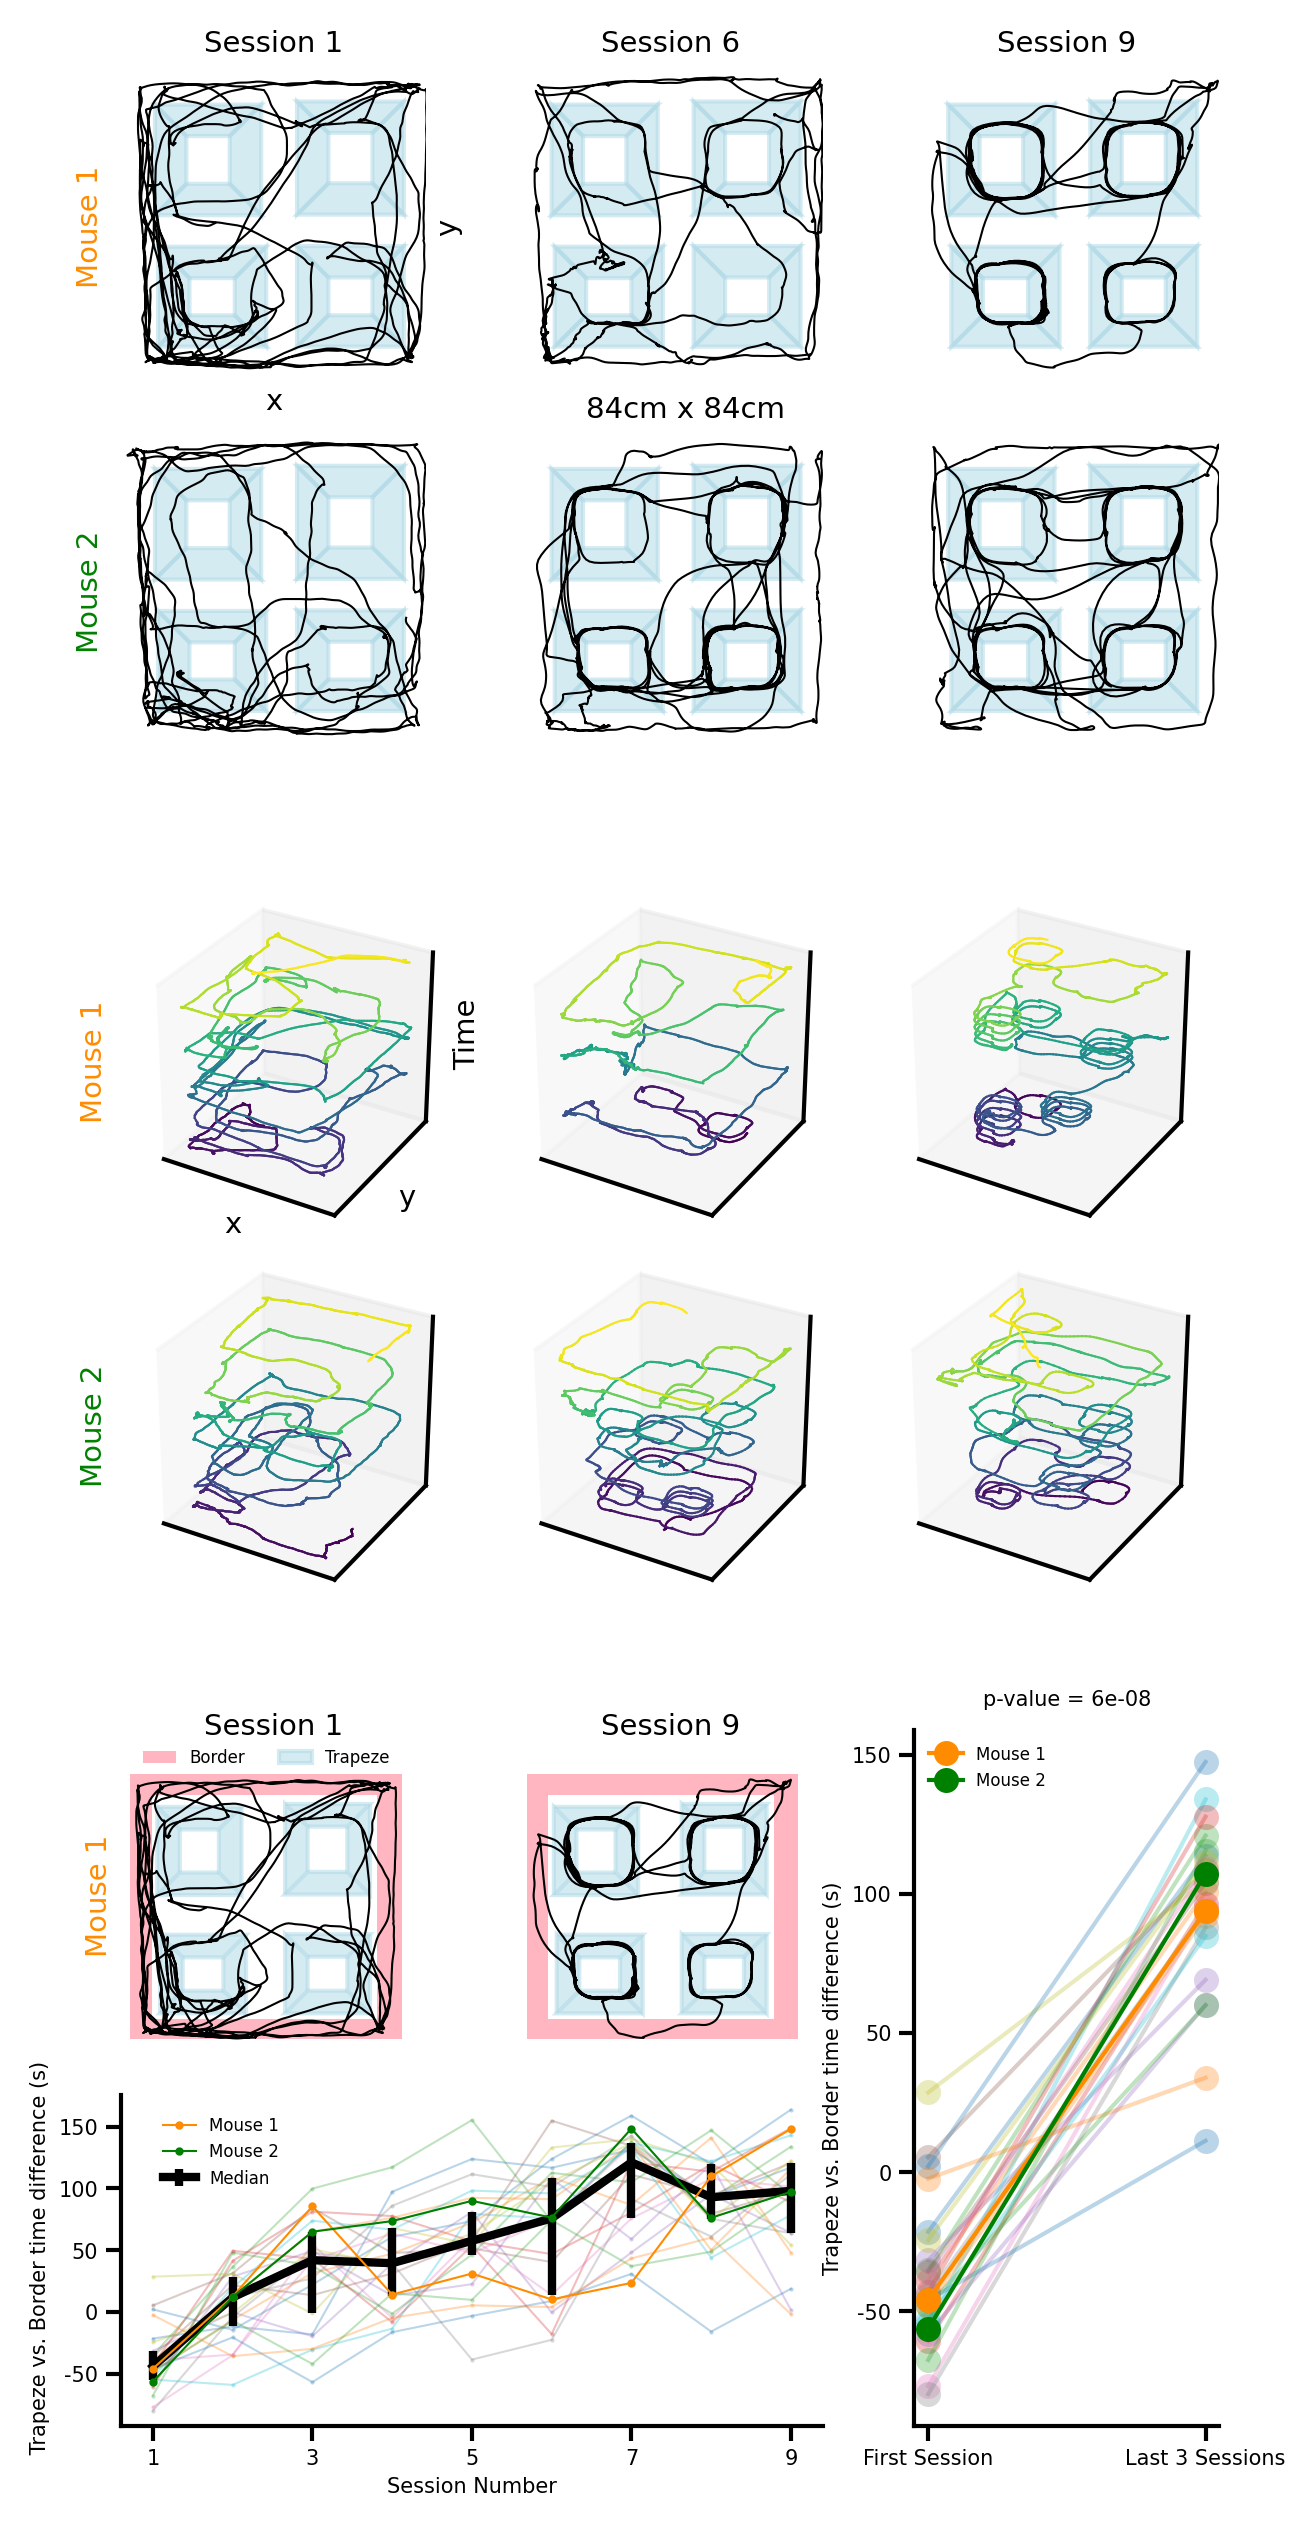

In [17]:
# cm2inch(18), cm2inch(26)
fig=plt.figure(figsize=(cm2inch(12), cm2inch(26)), dpi=300, constrained_layout=False, facecolor='w')
#fig = plt.figure(figsize=(18/2.54, 13/2.54),dpi=300)
gs = fig.add_gridspec(6, 1 , hspace=0.5, height_ratios=[1, 1, 1, 1, 1, 1])
#gs = GridSpec(8, 6, figure=fig)

#########################################################################################################

row1 = gs[0:2].subgridspec(2, 3, wspace=.3, hspace=.1, width_ratios=[1, 1, 1])
ax_11 = plt.subplot(row1[0,0], aspect="equal")
ax_12 = plt.subplot(row1[0,1], aspect="equal")
ax_13 = plt.subplot(row1[0,2], aspect="equal")


axs_1top = [ax_11,ax_12,ax_13]
axs_1top = np.array(axs_1top)

plot_mice_sessions([mice_to_compare[0]], sessions_to_compare, path_to_data_folder, time_start=time_start, time_end=time_end, axs=axs_1top, linewidth=0.5)

#ax_11.spines["right"].set_visible(True)
#ax_11.spines["right"].set_position(('outward', 0))
#ax_11.spines["bottom"].set_visible(True)
#ax_11.spines["bottom"].set_position(('outward', 0))

ax_11.text(1.85, -0.1, '84cm x 84cm', va='center', ha='center', transform=ax_11.transAxes, fontsize=7)

#ax_11.set_xlabel(f'Session {sessions_to_compare[0]+1}')
#ax_11.xaxis.set_label_position('top') 
#ax_12.set_xlabel(f'Session {sessions_to_compare[1]+1}')
#ax_12.xaxis.set_label_position('top') 
#ax_13.set_xlabel(f'Session {sessions_to_compare[2]+1}')
#ax_13.xaxis.set_label_position('top') 
#ax_11.set_ylabel(f'Mouse 1', color='darkorange')

ax_11.set_xlabel(f'x')
ax_11.set_ylabel(f'y')
ax_11.yaxis.set_label_position('right')

ax_11.text(-0.1, 0.5, 'Mouse 1', color='darkorange',rotation=90, va='center', ha='center', transform=ax_11.transAxes, fontsize=7)
ax_11.text(0.5, 1.1, f'Session {sessions_to_compare[0]+1}', va='center', ha='center', transform=ax_11.transAxes, fontsize=7)
ax_12.text(0.5, 1.1, f'Session {sessions_to_compare[1]+1}', va='center', ha='center', transform=ax_12.transAxes, fontsize=7)
ax_13.text(0.5, 1.1, f'Session {sessions_to_compare[2]+1}', va='center', ha='center', transform=ax_13.transAxes, fontsize=7)


#########

ax_14 = plt.subplot(row1[1,0], aspect="equal")
ax_15 = plt.subplot(row1[1,1], aspect="equal")
ax_16 = plt.subplot(row1[1,2], aspect="equal")

axs_1bot = [ax_14,ax_15,ax_16]
axs_1bot = np.array(axs_1bot)

plot_mice_sessions([mice_to_compare[1]], sessions_to_compare, path_to_data_folder, time_start=time_start, time_end=time_end, axs=axs_1bot, linewidth=0.5)

#ax_14.set_ylabel(f'Mouse 2', color='green')
ax_14.text(-0.1, 0.5, 'Mouse 2', color='green',rotation=90, va='center', ha='center', transform=ax_14.transAxes, fontsize=7)

#########################################################################################################

row2 = gs[2:4].subgridspec(2, 3, wspace=.1, hspace=.1, width_ratios=[1, 1, 1])
ax_21 = plt.subplot(row2[0,0], projection="3d", aspect="equal")
ax_22 = plt.subplot(row2[0,1], projection="3d", aspect="equal")
ax_23 = plt.subplot(row2[0,2], projection="3d", aspect="equal")

axs_2top = [ax_21,ax_22,ax_23]
axs_2top = np.array(axs_2top)

plot_3dtrajectory_mice_sessions([mice_to_compare[0]], sessions_to_compare, path_to_data_folder, time_start=time_start, time_end=time_end, axs=axs_2top, linewidth=0.5)

ax_21.set_xlabel('x', labelpad=-15)
ax_21.set_ylabel('y', labelpad=-15)
ax_21.set_zlabel('Time', labelpad=-15, rotation='vertical')

ax_21.text2D(-0.1, 0.5, 'Mouse 1', color='darkorange',rotation=90, va='center', ha='center', transform=ax_21.transAxes, fontsize=7)

#########

ax_24 = plt.subplot(row2[1,0], projection="3d", aspect="equal")
ax_25 = plt.subplot(row2[1,1], projection="3d", aspect="equal")
ax_26 = plt.subplot(row2[1,2], projection="3d", aspect="equal")


axs_2bot = [ax_24,ax_25,ax_26]
axs_2bot = np.array(axs_2bot)

plot_3dtrajectory_mice_sessions([mice_to_compare[1]], sessions_to_compare, path_to_data_folder, time_start=time_start, time_end=time_end, axs=axs_2bot, linewidth=0.5)

ax_24.text2D(-0.1, 0.5, 'Mouse 2', color='green', rotation=90, va='center', ha='center', transform=ax_24.transAxes, fontsize=7)


#########################################################################################################

row3 = gs[4:].subgridspec(2, 3, wspace=.3, hspace=.1, width_ratios=[1, 1, 1])
ax_31 = plt.subplot(row3[0,0], aspect="equal")
ax_32 = plt.subplot(row3[0,1], aspect="equal")
ax_33 = plt.subplot(row3[1,:2])
ax_34 = plt.subplot(row3[0:,2])

plot_trajectory_with_areas(os.path.join(path_to_data_folder, mice_to_compare[0]), session_list, sessions_to_compare[0], border_zone, trapeze_width, ax=ax_31, time_start=time_start, time_end=time_end, linewidth=0.5)
plot_trajectory_with_areas(os.path.join(path_to_data_folder, mice_to_compare[0]), session_list, sessions_to_compare[-1], border_zone, trapeze_width, ax=ax_32, time_start=time_start, time_end=time_end, linewidth=0.5, display_legend=False)

ax_31.set_xlabel(f'Session {sessions_to_compare[0]+1}')
ax_31.xaxis.set_label_position('top') 
ax_31.set_ylabel('Mouse 1', color='darkorange')
ax_32.set_xlabel(f'Session {sessions_to_compare[-1]+1}')
ax_32.xaxis.set_label_position('top') 

#plot_learning_curves(mouse_timeratio_trapezevsborder_persession, mice_to_highlight=mice_to_compare, axs=ax_33, session_limit=session_limit, ylabel=' Trapeze vs. Border time ratio', title='', tick_interval=2, ylim=[0, 4.5])

#plot_all_mice_first_vs_last_sessions_time_ratio(mouse_timeratio_trapezevsborder_persession, mice_to_analyse, ax=ax_34, session_limit=session_limit-1, mice_to_highlight=mice_to_compare, last_n_sessions=3, ylim=[0,8], ylabel='Trapeze vs. Border time ratio')

plot_learning_curves(mouse_timediff_trapezevsborder_persession, mice_to_highlight=mice_to_compare, axs=ax_33, session_limit=session_limit, ylabel=' Trapeze vs. Border time difference (s)', title='', tick_interval=2)

plot_all_mice_first_vs_last_sessions(mouse_timediff_trapezevsborder_persession, mice_to_analyse, ax=ax_34, session_limit=session_limit, mice_to_highlight=mice_to_compare, last_n_sessions=3, ylabel='Trapeze vs. Border time difference (s)')

#########################################################################################################

### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ###
#plt.tight_layout()

plt.show()
    

In [18]:
len(mice_to_analyse)

25

In [19]:
# Identifying sessions following a weekend

days_since_last_session = []

n = 0

for mouse in mice_list:

    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    days_since_last_session.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[9:13]) 
        month = int(session_name[13:15])
        day = int(session_name[15:17])

        previous_year = int(previous_session_name[9:13]) 
        previous_month = int(previous_session_name[13:15])
        previous_day = int(previous_session_name[15:17])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        days_since_last_session[n].append(delta.days)

    n = n + 1


mice_to_analyse = []
rejected_mice = []

for i in range(len(mice_list)):

    nb_sessions = len(days_since_last_session[i]) + 1

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    consecutive_sessions = [0]
    k = 0

    print(f"#### {mice_list[i]} ####")

    for j in range(nb_sessions):

        if not(j+1 in sessions_after_weekend):

            consecutive_sessions[k] += 1

        else:

            consecutive_sessions.append(1)
            k += 1

    print("Length of consecutive sessions periods: ", consecutive_sessions)
    print("ID of sessions following a weekend: ", sessions_after_weekend)
    print("Days since last sessions: ", days_since_last_session[i])

    if len(consecutive_sessions)>1:

        if consecutive_sessions[0] == 1:

            is_good_series = np.sum(consecutive_sessions[:2])>=9
            is_good_series = is_good_series and consecutive_sessions[2]>=9

        else:
            
            is_good_series = consecutive_sessions[0]>=9 and consecutive_sessions[1]>=9
        
    else:

        is_good_series = np.sum(consecutive_sessions[:1])>18

    # if len(consecutive_sessions) > 1:
    
    #     is_pause_at_good_time = (consecutive_sessions[0] == 1 or consecutive_sessions[0]>=11)

    # else:

    #     is_pause_at_good_time = True


    elimination_condition = not(is_good_series)
    #elimination_condition = not(is_big_series and is_pause_at_good_time)
    #elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)


    if elimination_condition :

        rejected_mice.append(mice_list[i])

        #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Removing this mouse", "\n")

    else:

        mice_to_analyse.append(mice_list[i])

        #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Keeping this mouse", "\n")



"""    elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)

    sessions_before_limit = np.where(elimination_condition)[0]

    if sessions_before_limit.size == 0 :

        #mice_to_analyse.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Keeping this mouse")

    else:

        #rejected_mice.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Removing this mouse")
"""


#### MOUKA266 ####
Length of consecutive sessions periods:  [5, 10, 2]
ID of sessions following a weekend:  [ 6 16]
Days since last sessions:  [1, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3, 0]
Removing this mouse 

#### MOUKA267 ####
Length of consecutive sessions periods:  [5, 9, 4]
ID of sessions following a weekend:  [ 6 15]
Days since last sessions:  [1, 0, 1, 0, 3, 0, 1, 1, 0, 1, 0, 1, 0, 3, 0, 1, 0]
Removing this mouse 

#### MOUKA268 ####
Length of consecutive sessions periods:  [5, 6]
ID of sessions following a weekend:  [6]
Days since last sessions:  [1, 0, 1, 0, 3, 0, 1, 0, 1, 0]
Removing this mouse 

#### MOUKA269 ####
Length of consecutive sessions periods:  [5, 8]
ID of sessions following a weekend:  [6]
Days since last sessions:  [1, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0]
Removing this mouse 

#### MOUKA270 ####
Length of consecutive sessions periods:  [5, 9, 2]
ID of sessions following a weekend:  [ 6 15]
Days since last sessions:  [1, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 1, 3, 0]


'    elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)\n\n    sessions_before_limit = np.where(elimination_condition)[0]\n\n    if sessions_before_limit.size == 0 :\n\n        #mice_to_analyse.append(mice_list[i])\n\n        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)\n        print("Keeping this mouse")\n\n    else:\n\n        #rejected_mice.append(mice_list[i])\n\n        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)\n        print("Removing this mouse")\n'

In [20]:
print(mice_to_analyse)

['MOUKA279', 'MOUKA290', 'MOUKA291', 'MOUKA298', 'MOUKA307', 'MOUKA310']
